#**Salifort Motors**

---



#### *Retención de empleados*

>



### Entendiendo el escenario de negocio y entendiendo el problema

El departamento de Recursos Humanos de Salifort Motors quiere tomar algunas iniciativas para mejorar los niveles de satisfacción de los empleados en la empresa. Recopilaron datos de los empleados, pero ahora no saben qué hacer con ellos. Se refieren a ti como profesional de análisis de datos y te piden que proporciones sugerencias basadas en datos, según tu comprensión de los mismos. Tienen la siguiente pregunta: ¿qué es lo que probablemente haga que el empleado abandone la empresa?

Tus objetivos en este proyecto son analizar los datos recopilados por el departamento de RRHH y construir un modelo que prediga si un empleado abandonará o no la empresa.

Si puedes predecir qué empleados tienen probabilidades de renunciar, podría ser posible identificar los factores que contribuyen a su partida. Dado que encontrar, entrevistar y contratar nuevos empleados lleva tiempo y es costoso, aumentar la retención de empleados será beneficioso para la empresa.

### Diccionario de los datos de RH

En este [dataset](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv), tenemos 14,999 filas, 10 columnas, y las siguientes variables:

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

In [ ]:
# Importando librerias necesarias para construir nuestro modelo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# Para procear datos del modelo
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Metricas y funciones de ayuda
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# Para guardar el modelo
import pickle

In [ ]:
# Cargando el dataset
data = pd.read_csv('HR_comma_sep.csv')
data.head(5)

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

## 2.- Exploración de la data (EDA and data clean)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Generamos estadisticas descriptivas sobre los datos


In [ ]:
data.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

### Renombar columnas

Para mayor comodidad renombramos algunas columnas, estandarizando con el snake_casa

In [ ]:
# imprimiendo los nombres de las columnas
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [ ]:
data = data.rename(columns = {'Work_accident': 'work_accident',
                              'average_montly_hours': 'average_monthly_hours',
                              'time_spend_company' : 'tenure',
                              'Department':'department'})
data.columns


Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

Buscamos si es que hay datos perdidos o nulos

In [ ]:
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

Notanos que no hay datos vacios

In [ ]:
# Buscamos datos duplicados
data.duplicated().sum()

np.int64(3008)

Es el numero de coolumnas que tenemos duplicadas

In [ ]:
# Inspeccionamos los datos duplicados
data[data.duplicated()].head()

satisfaction_level  last_evaluation  number_project  \
396                 0.46             0.57               2   
866                 0.41             0.46               2   
1317                0.37             0.51               2   
1368                0.41             0.52               2   
1461                0.42             0.53               2   

      average_monthly_hours  tenure  work_accident  left  \
396                     139       3              0     1   
866                     128       3              0     1   
1317                    127       3              0     1   
1368                    132       3              0     1   
1461                    142       3              0     1   

      promotion_last_5years  department  salary  
396                       0       sales     low  
866                       0  accounting     low  
1317                      0       sales  medium  
1368                      0       RandD     low  
1461                      0       sales     low

In [ ]:
# Eliminamos las columnas duplicadas
data = data.drop_duplicates(keep='first')
data.head()


satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years department  salary  
0       3              0     1                      0      sales     low  
1       6              0     1                      0      sales  medium  
2       4              0     1                      0      sales  medium  
3       5              0     1                      0      sales     low  
4       3              0     1                      0      sales     low

Checamos si existen datos atipicos en los datos

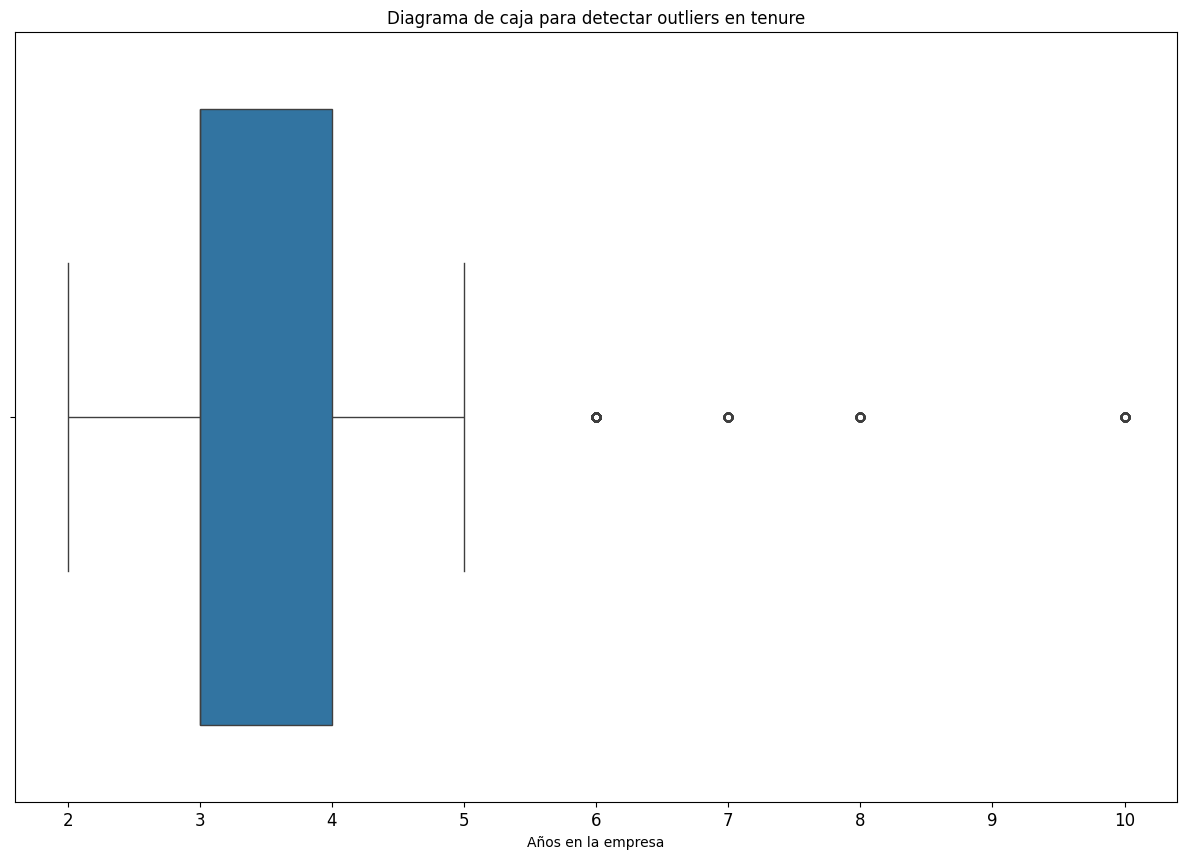

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Diagrama de caja para detectar outliers en tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Años en la empresa')
plt.yticks(fontsize = 12)
sns.boxplot(x=data['tenure'])
plt.show()

La grafica nos muestra muestra los datos atipicos de la columna tenure = tiempo de permanencia en la empresa.



In [ ]:
# Determinamos el número de filas que contienen los datos atipicos

percentile25 = data['tenure'].quantile(0.25)
percentile75 = data['tenure'].quantile(0.75)

# Calculamos el rango del intercuartile
iqr = percentile75 - percentile25

# Definimos el limite superior e inferior para los valores no atipicos
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print(f'Limite superior:{upper_limit}')
print(f'Limite inferior:{lower_limit}')

# Identificamos el subgrupo de los datos

outliers = data[(data['tenure']>upper_limit)| (data['tenure']<lower_limit)]

print(f'Numero de filas con datos atipicos:{outliers.shape[0]}')

Limite superior:5.5
Limite inferior:1.5
Numero de filas con datos atipicos:824


Empezando por entender como los empleados se van y  que porcentaje de todos los empleados representan la figura.

In [ ]:
# Obtenemos el numero de personas que se van contra los que se quedan
print(data['left'].value_counts())
print()
# Otenemos porcentajes de personas que se van contra los que se quedan
print(data['left'].value_counts(normalize = True))

left
0    10000
1     1991
Name: count, dtype: int64

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


## Visualización de datos
Hacemos visualizaciones para 'average_monthly_hours', 'number_project'

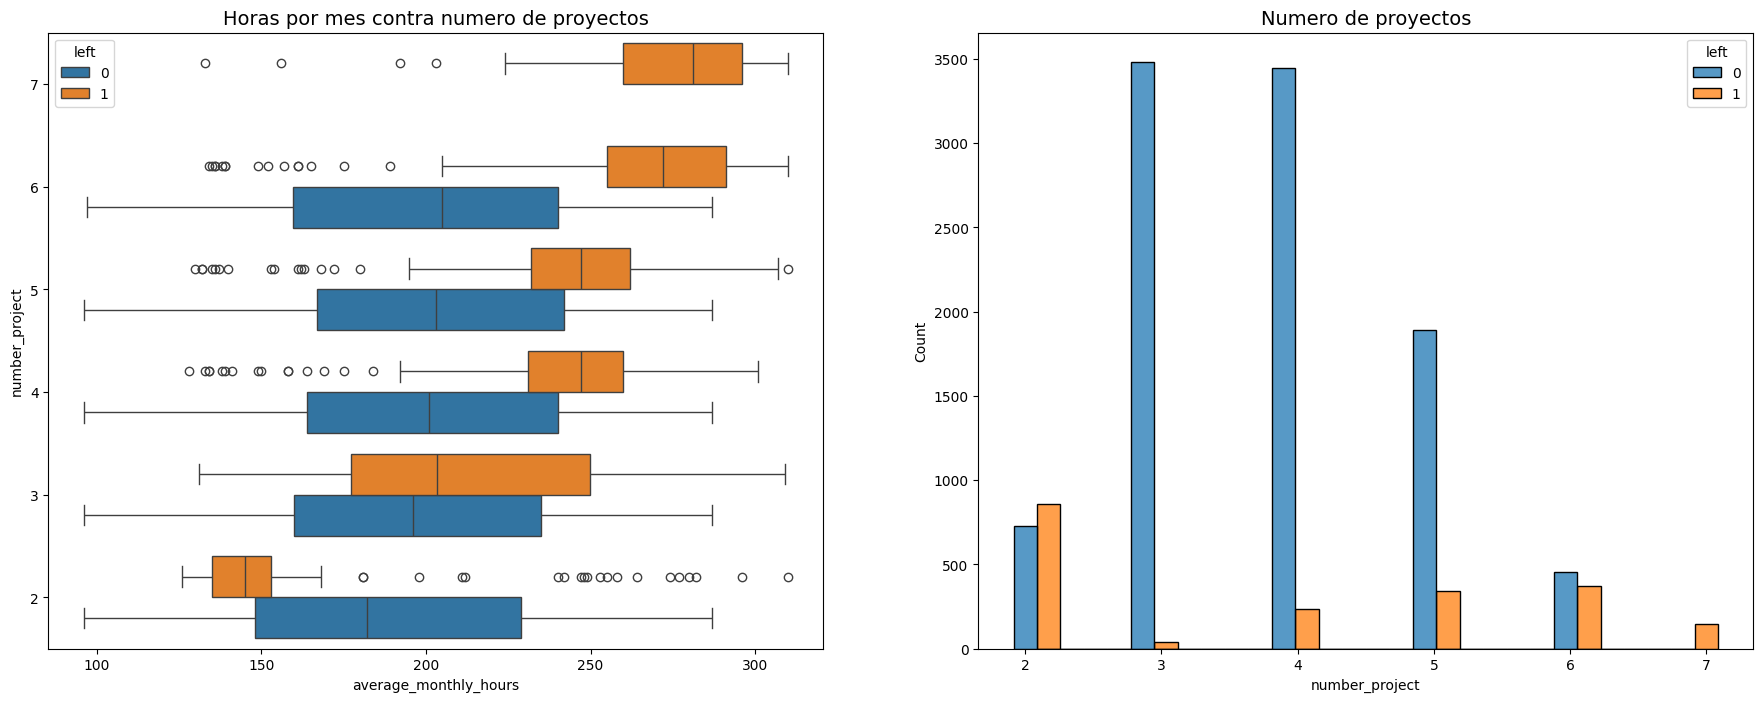

In [ ]:

fig, ax = plt.subplots(1,2, figsize = (22,8))

# Grafico de caja
sns.boxplot(data = data, x = 'average_monthly_hours',y = 'number_project', hue= 'left',orient='h',ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Horas por mes contra numero de proyectos', fontsize = '14')

# Histograma
tenure_stay = data[data['left']==0]['number_project']
tenure_left = data[data['left']==1]['number_project']
sns.histplot(data = data, x= 'number_project', hue = 'left',multiple='dodge',shrink =2, ax=ax[1])
ax[1].set_title('Numero de proyectos', fontsize = '14')
plt.show()

Puede ser natural que las personas que trabajan en más proyectos también trabajen más horas. Este parece ser el caso aquí, con el promedio de horas de cada grupo (los que se quedaron y los que se fueron) aumentando con el número de proyectos trabajados. Sin embargo, algunas cosas destacan de este gráfico.

Hay dos grupos de empleados que dejaron la empresa: (A) aquellos que trabajaron considerablemente menos que sus compañeros con el mismo número de proyectos, y (B) aquellos que trabajaron mucho más. De los del grupo A, es posible que fueran despedidos. También es posible que este grupo incluya empleados que ya habían notificado su salida y se les asignaron menos horas porque ya estaban a punto de irse. Para los del grupo B, es razonable inferir que probablemente renunciaron. Es probable que las personas del grupo B hayan contribuido mucho a los proyectos en los que trabajaron; podrían haber sido los mayores contribuyentes a sus proyectos.
Todos los que tenían siete proyectos dejaron la empresa, y los rangos intercuartílicos de este grupo y los que se fueron con seis proyectos fueron de ~255 a 295 horas/mes, mucho más que cualquier otro grupo.
El número óptimo de proyectos en los que los empleados deben trabajar parece ser de 3 a 4. La proporción de "se fueron" / "se quedaron" es muy pequeña para estas cohortes.
Si asumes una semana laboral de 40 horas y dos semanas de vacaciones al año, entonces el número promedio de horas de trabajo por mes de los empleados que trabajan de lunes a viernes es = 50 semanas * 40 horas por semana / 12 meses = 166.67 horas por mes. Esto significa que, aparte de los empleados que trabajaron en dos proyectos, todos los grupos, incluso aquellos que no dejaron la empresa, trabajaron considerablemente más horas que esto. Parece que los empleados aquí están sobrecargados de trabajo.

In [ ]:
#obteniendo cuantos valores de se quedaron/ se fueron  para los empleados con 7 proyectos
data[data['number_project']==7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

Esto confirma que todos los empleados con 7 proyectos se fueron.


ahora examinaremos el promedio de horas al mes contra el nivel de satisfacción.

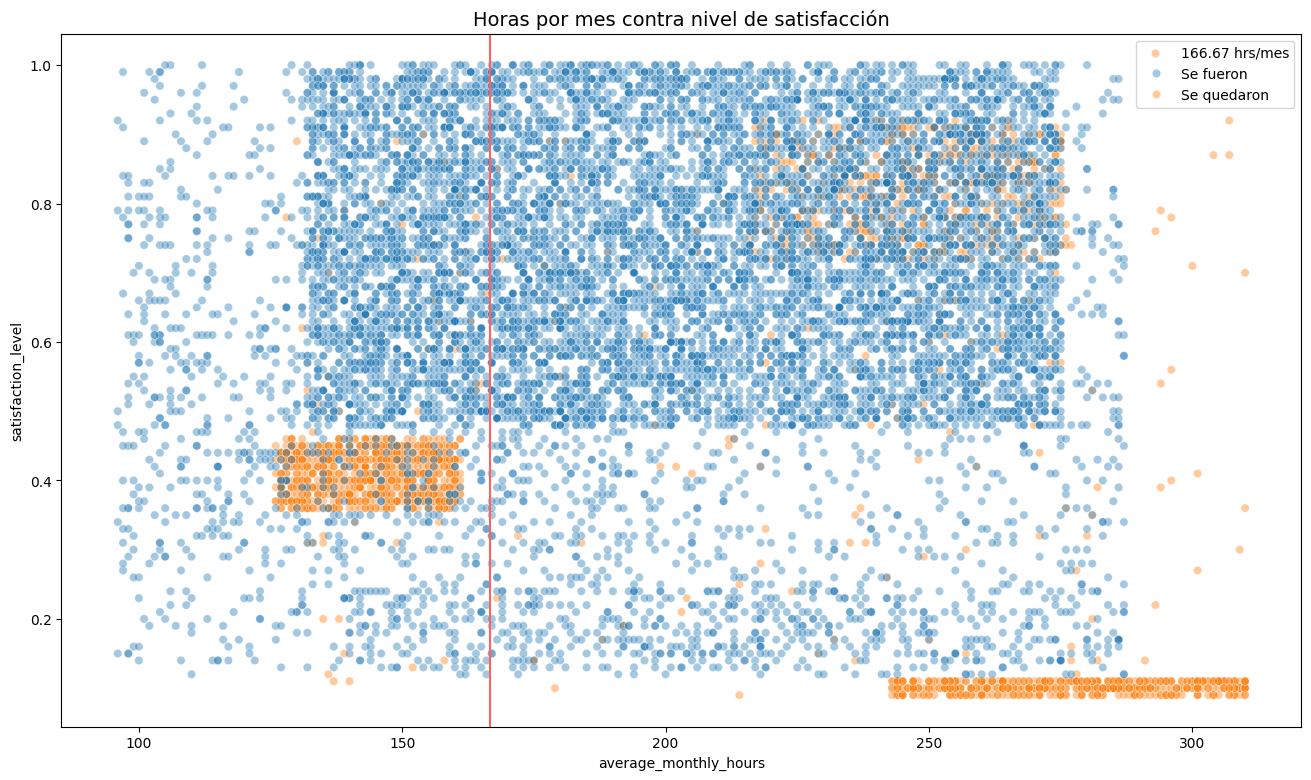

In [ ]:
#  Creamos un grafico de dispersion
plt.figure(figsize=(16,9))
sns.scatterplot(data=data, x='average_monthly_hours', y = 'satisfaction_level', hue='left', alpha =0.4 )
plt.axvline(x=166.67, color='#ff6361',label = '166.67 hrs/month', ls = '-')
plt.legend(labels=['166.67 hrs/mes','Se fueron','Se quedaron'])
plt.title('Horas por mes contra nivel de satisfacción', fontsize = '14');

El gráfico de dispersión anterior muestra que hubo un grupo considerable de empleados que trabajaron entre ~240 y 315 horas al mes. 315 horas al mes son más de 75 horas a la semana durante todo un año. Es probable que esto esté relacionado con sus niveles de satisfacción, que están cerca de cero.

El gráfico también muestra otro grupo de personas que se fueron, aquellos que tenían horas de trabajo más normales. A pesar de ello, su satisfacción era solo alrededor de 0.4. Es difícil especular sobre por qué se pudieron haber ido. Es posible que se sintieran presionados a trabajar más, considerando que muchos de sus compañeros trabajaban más. Y esa presión podría haber reducido sus niveles de satisfacción.

Finalmente, hay un grupo que trabajó entre ~210 y 280 horas al mes, y tenían niveles de satisfacción que oscilaban entre ~0.7 y 0.9.

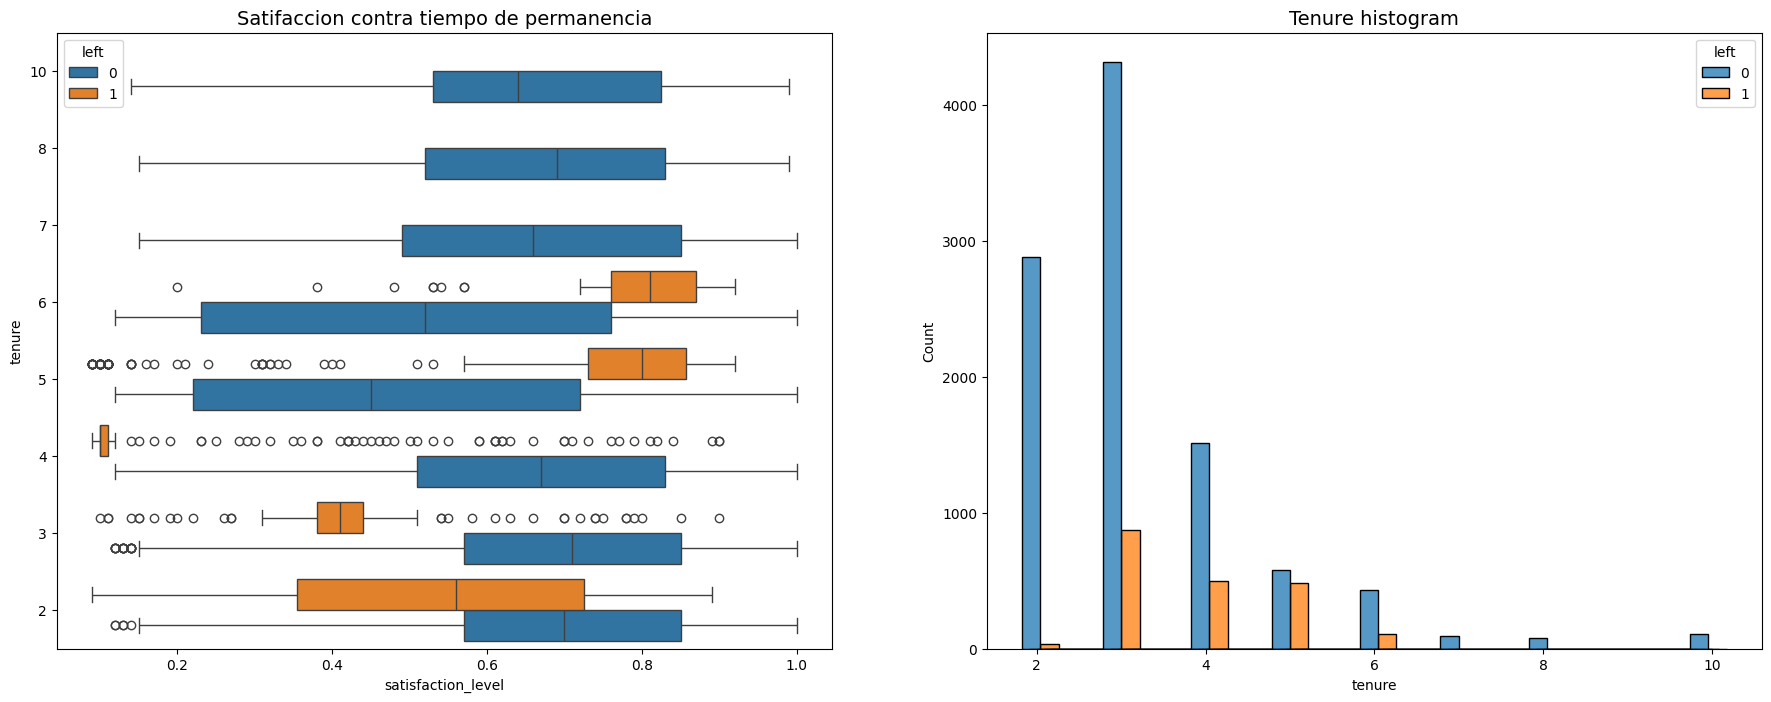

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(22,8))

# Diagrama de caja
sns.boxplot(data=data, x = 'satisfaction_level', y = 'tenure', hue='left', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satifaccion contra tiempo de permanencia', fontsize ='14')

# Histograma
tenure_stay = data[data['left']==0]['tenure']
tenure_left = data[data['left']==1]['tenure']
sns.histplot(data=data, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')
plt.show()


- Los empleados que se fueron se dividen en dos categorías generales: empleados insatisfechos con antigüedad más corta y empleados muy satisfechos con antigüedad de duración media.
- Los empleados con cuatro años de antigüedad que se fueron parecen tener un nivel de satisfacción inusualmente bajo. Vale la pena investigar los cambios en la política de la empresa que podrían haber afectado a las personas específicamente en la marca de los cuatro años, si es posible.
- Los empleados con mayor antigüedad no se fueron. Sus niveles de satisfacción se alinearon con los de los empleados más nuevos que se quedaron.
- El histograma muestra que hay relativamente pocos empleados con mayor antigüedad. Es posible que sean los empleados de mayor rango y mejor pagados.


In [ ]:
data.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

/tmp/ipython-input-3882085532.py:1: FutureWarning: The provided callable <function mean at 0x7e51a7f51c60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])
/tmp/ipython-input-3882085532.py:1: FutureWarning: The provided callable <function median at 0x7e51a539df80> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  data.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])


mean  median
left                  
0     0.667365    0.69
1     0.440271    0.41

Como era de esperar, las puntuaciones medias y medianas de satisfacción de los empleados que se fueron son más bajas que las de los empleados que se quedaron. Curiosamente, entre los empleados que se quedaron, la puntuación media de satisfacción parece estar ligeramente por debajo de la puntuación mediana. Esto indica que los niveles de satisfacción entre los que se quedaron podrían estar sesgados hacia la izquierda.

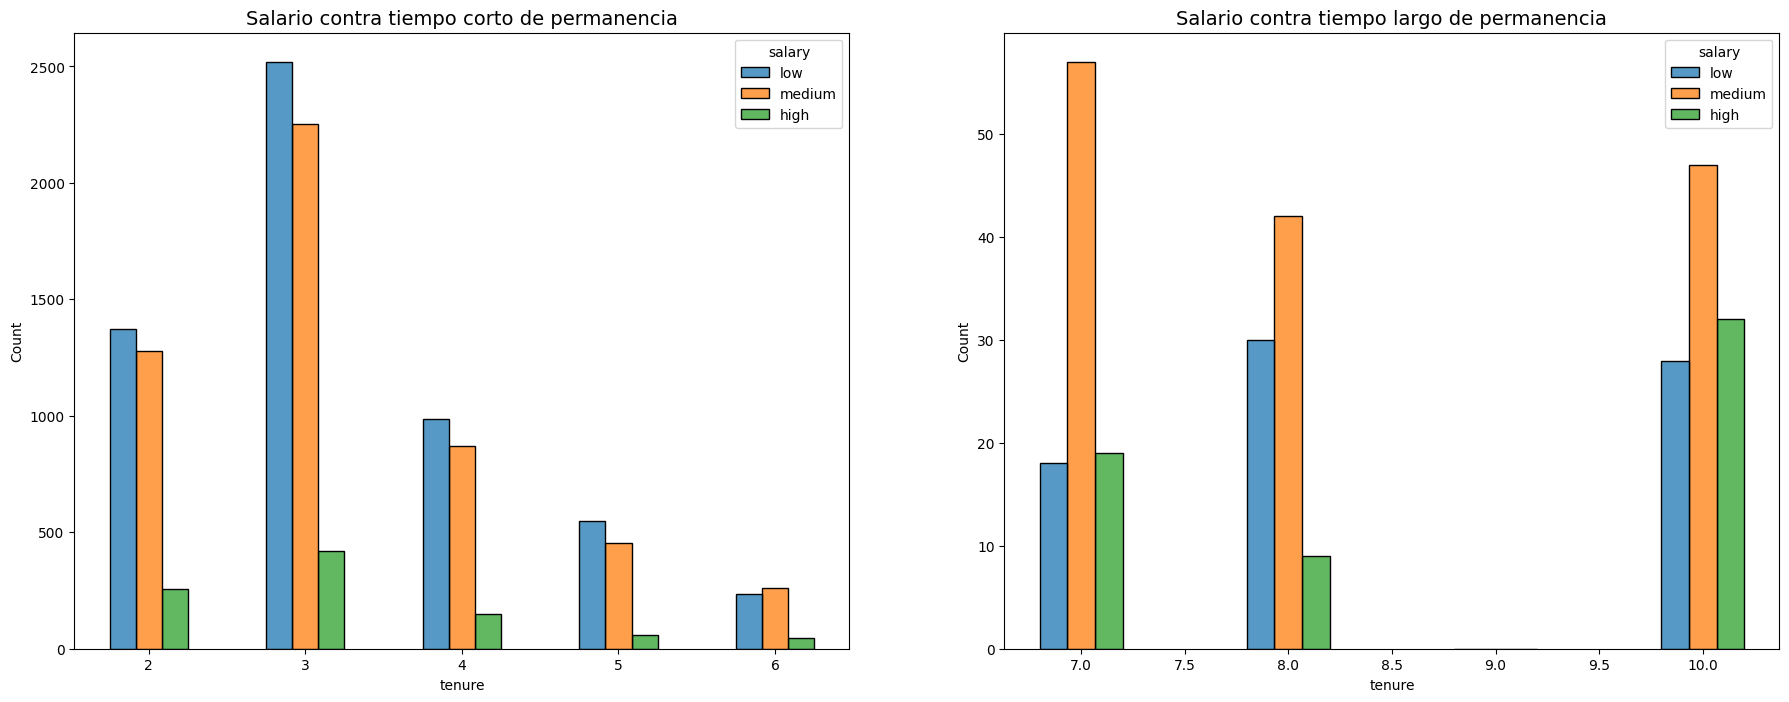

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(22,8))

# Definimos el tipo de permanencia de los empleados
tenure_short = data[data['tenure']<7]
tenure_long = data[data['tenure']>6]

# Histogramas
sns.histplot(data = tenure_short,x='tenure',hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'],multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salario contra tiempo corto de permanencia', fontsize='14')

sns.histplot(data = tenure_long,x='tenure',hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'],multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salario contra tiempo largo de permanencia', fontsize='14');


Los gráficos anteriores muestran que los empleados con antigüedad no necesariamente estaban desproporcionadamente compuestos por empleados mejor pagados.

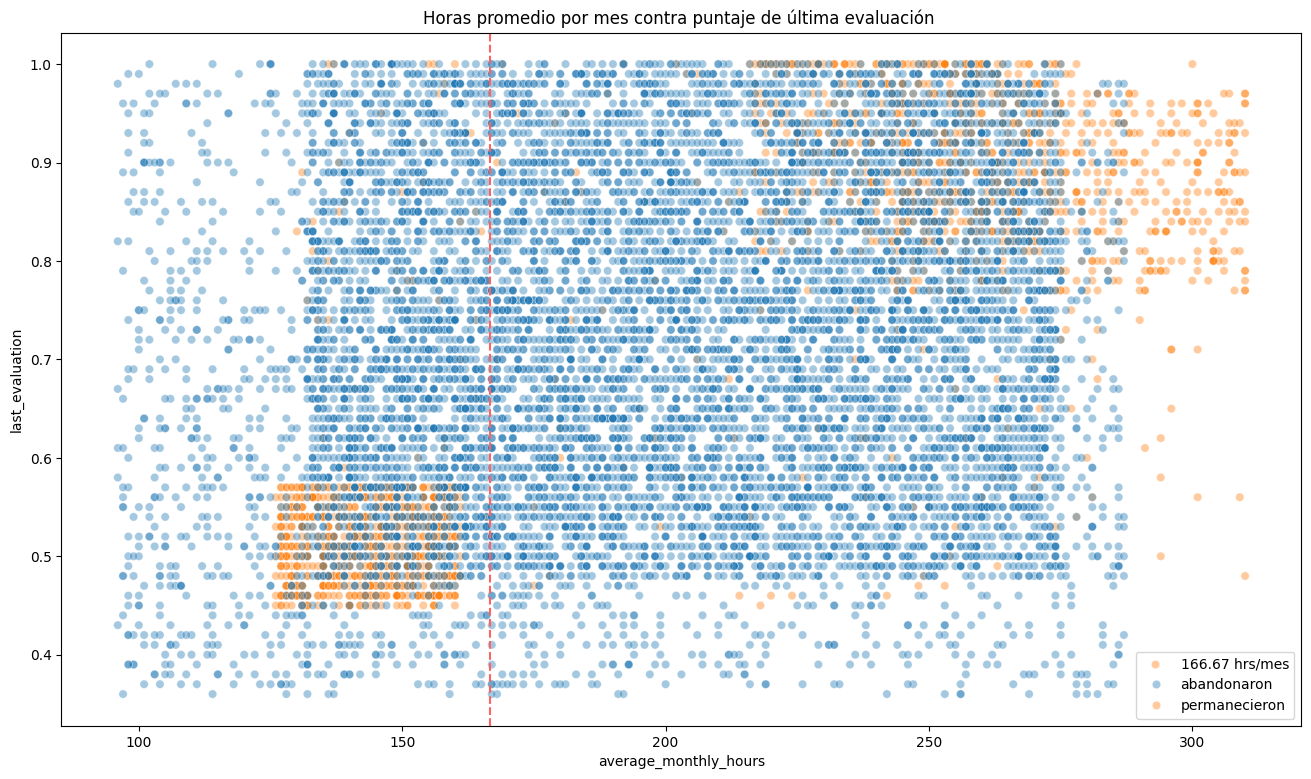

In [ ]:
# Creamos una grafica de dispersion
plt.figure(figsize=(16,9))
sns.scatterplot(data=data, x='average_monthly_hours', y= 'last_evaluation',hue='left', alpha = 0.4 )
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs/mes', ls='--')
plt.legend(labels=['166.67 hrs/mes','abandonaron', 'permanecieron'])
plt.title('Horas promedio por mes contra puntaje de última evaluación ')
plt.show()

**Observaciones**

- El gráfico de dispersión indica dos grupos de empleados que se fueron: empleados sobrecargados de trabajo que tuvieron un muy buen desempeño y empleados que trabajaron ligeramente por debajo del promedio mensual nominal de 166.67 horas con puntuaciones de evaluación más bajas.
- Parece haber una correlación entre las horas trabajadas y la puntuación de evaluación.
- No hay un alto porcentaje de empleados en el cuadrante superior izquierdo de este gráfico; pero trabajar muchas horas no garantiza una buena puntuación de evaluación.
- La mayoría de los empleados de esta empresa trabajan bastante más de 167 horas al mes.

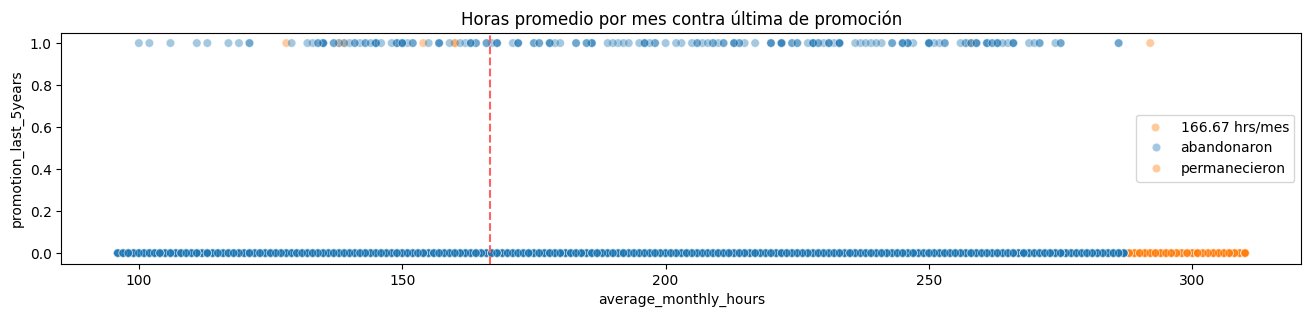

In [ ]:
# Creamos un grafico de dispersion
plt.figure(figsize=(16,3))
sns.scatterplot(data=data,x='average_monthly_hours',y='promotion_last_5years', hue='left',alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs/mes','abandonaron', 'permanecieron'])
plt.title('Horas promedio por mes contra última de promoción')
plt.show()

- Muy pocos empleados que fueron ascendidos en los últimos cinco años se fueron.
- Muy pocos empleados que trabajaron la mayor cantidad de horas fueron ascendidos.
- Todos los empleados que se fueron estaban trabajando la mayor cantidad de horas.

In [ ]:
# Inspeccionando la dsitribucion de empleados que se fuerin en los departamentos
data['department'].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

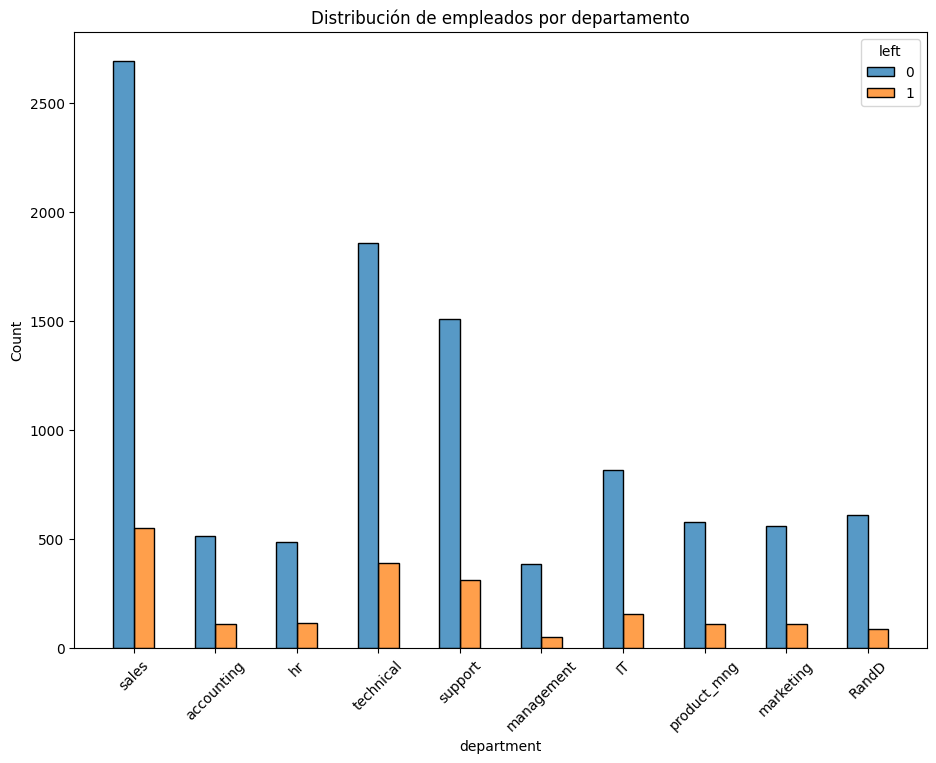

In [ ]:
plt.figure(figsize=(11,8))
sns.histplot(data=data,x='department',hue='left',discrete=1,
             hue_order=[0,1],multiple='dodge',shrink=.5)
plt.xticks(rotation=45)
plt.title('Distribución de empleados por departamento')
plt.show()

Notamos que no hay diferencias significativas entre los empleados que se quedan o abandonan

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'satisfaction_level'),
  Text(1.5, 0, 'last_evaluation'),
  Text(2.5, 0, 'number_project'),
  Text(3.5, 0, 'average_monthly_hours'),
  Text(4.5, 0, 'tenure'),
  Text(5.5, 0, 'work_accident'),
  Text(6.5, 0, 'left'),
  Text(7.5, 0, 'promotion_last_5years')])

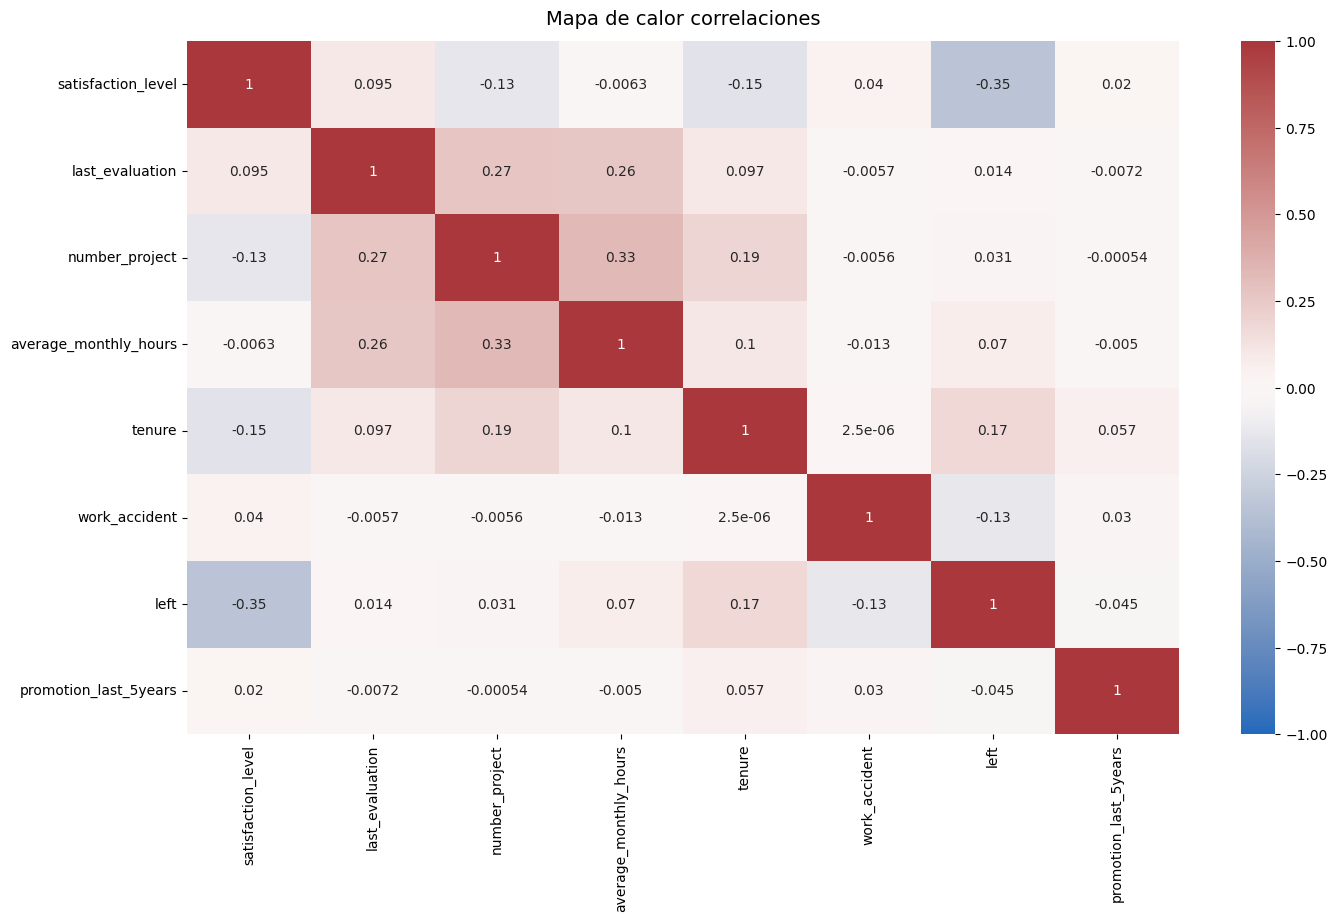

In [ ]:
# Ahora observamos las correlaciones con un mapa de calor
dt = data.loc[:,['satisfaction_level','last_evaluation','number_project',
                 'average_monthly_hours','tenure','work_accident','left','promotion_last_5years']]

plt.figure(figsize=(16,9))
heatmap = sns.heatmap(dt.corr(), vmin=-1,vmax=1,annot=True,
                      cmap=sns.color_palette('vlag',as_cmap=True))
heatmap.set_title('Mapa de calor correlaciones',fontdict={'fontsize':14},pad=12);
plt.xticks(rotation='vertical')

El mapa de calor de correlación confirma que el número de proyectos, las horas mensuales y las puntuaciones de evaluación tienen una correlación positiva entre sí, y si un empleado se va, está negativamente correlacionado con su nivel de satisfacción.


##Resumen:

Parece que los empleados se van de la empresa como resultado de una mala gestión. La salida está relacionada con horas de trabajo más largas, muchos proyectos y, en general, niveles de satisfacción más bajos. Puede ser poco gratificante trabajar largas horas y no recibir ascensos o buenas puntuaciones de evaluación. Hay un grupo considerable de empleados en esta empresa que probablemente estén agotados. También parece que si un empleado ha pasado más de seis años en la empresa, tiende a no irse.


# Construcción del módelo

## Regresión logistica

Esta sera una regresion logistica binaria por que las salidas que buscamos es solo 1 o 0 de la columna `leaft`.
Antes de empezar con la división de los datos convertimos las variables no numericas como lo son `department` y `salary`

In [ ]:
# Copia de los datos
dt1 = data.copy()
# cambiamos los datos de 'salary' a una categoria numerica
dt1['salary'] = (dt1['salary'].astype('category').cat.set_categories(
    ['low','medium','high']).cat.codes
)

# Pasamos a variable dummy la columna 'deparment'
dt1 = pd.get_dummies(dt1, drop_first=False,dtype='int64')
dt1.head()


satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0              0   
1       6              0     1                      0       1              0   
2       4              0     1                      0       1              0   
3       5              0     1                      0       0              0   
4       3              0     1                      0       0              0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
1                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0

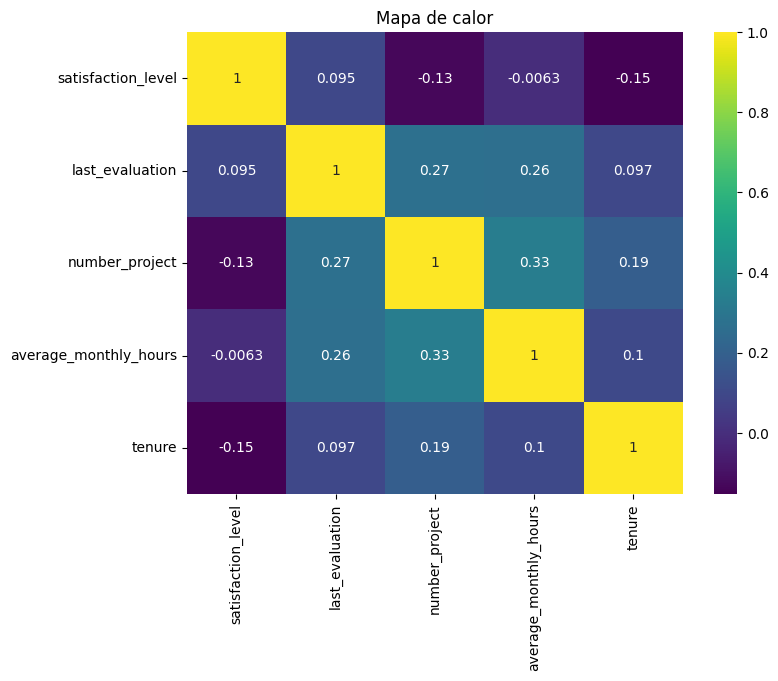

In [ ]:
# Creamos un mapa de calor
plt.figure(figsize=(8,6))
sns.heatmap(dt1[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(),annot=True,cmap='viridis')
plt.title('Mapa de calor')
plt.show()

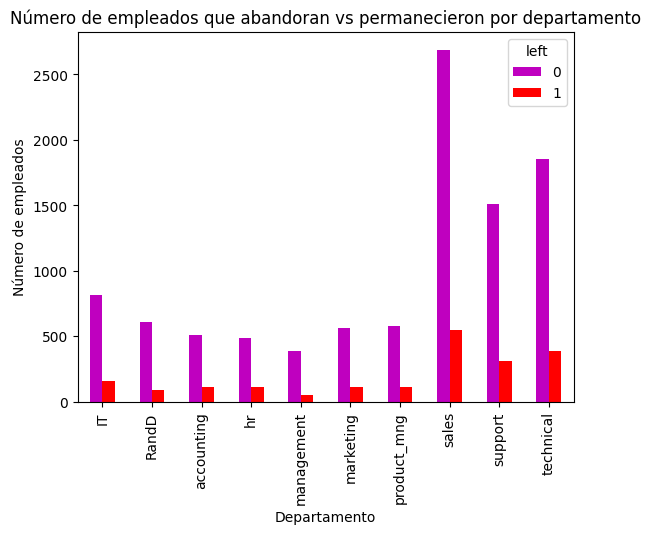

In [ ]:
pd.crosstab(data['department'],data['left']).plot(kind='bar', color='mr')
plt.title('Número de empleados que abandoran vs permanecieron por departamento')
plt.xlabel('Departamento')
plt.ylabel('Número de empleados')
plt.show()

Ahora para evitar errores en la regression logistica vamos a eliminar los valores atipicos de `tenure`

In [ ]:
# Eliminamos los datos atipicos
dt_log = dt1[(dt1['tenure']>= lower_limit)|(dt1['tenure']<= upper_limit)]
dt_log.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0              0   
1       6              0     1                      0       1              0   
2       4              0     1                      0       1              0   
3       5              0     1                      0       0              0   
4       3              0     1                      0       0              0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
1                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0

Ahora asignamos la variable a predecir


In [ ]:
# Asignado la variable a predecir
y=dt_log['left']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [ ]:
# Eliminamos la variable a predecir de nuestros datos
X = dt_log.drop('left',axis=1)
# Vemos el encabezado
X.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  promotion_last_5years  salary  department_IT  \
0       3              0                      0       0              0   
1       6              0                      0       1              0   
2       4              0                      0       1              0   
3       5              0                      0       0              0   
4       3              0                      0       0              0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
1                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0

In [ ]:
# Dividimos la data en los set de entrenamiento y prueba
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25,stratify=y,random_state=42)


In [ ]:
# Construimos la regresion logistica
log_c = LogisticRegression(random_state=42,max_iter=500).fit(x_train,y_train)

# Predecimos algunos valores con el modelo
y_pred = log_c.predict(x_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


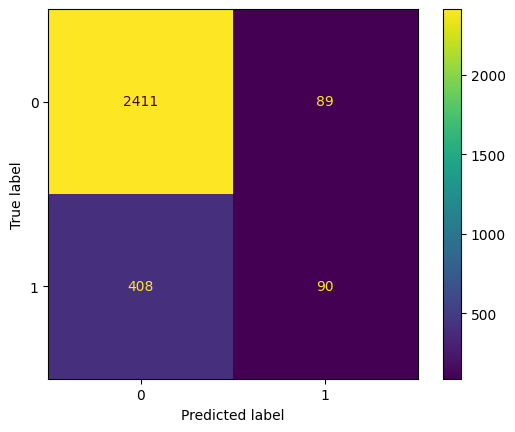

In [ ]:
#Visualizamos los calores con una matrix de confusion
log_cm = confusion_matrix(y_test,y_pred,labels=log_c.classes_)

# Imagen de la matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,display_labels=log_c.classes_)

# Graficamos la matrix
log_disp.plot(values_format='')

plt.show()


El cuadrante superior izquierdo muestra el número de verdaderos negativos. El cuadrante superior derecho muestra el número de falsos positivos. El cuadrante inferior izquierdo muestra el número de falsos negativos. El cuadrante inferior derecho muestra el número de verdaderos positivos.

- Verdaderos negativos: El número de personas que no se fueron y que el modelo predijo con precisión que no se irían.

- Falsos positivos: El número de personas que no se fueron y que el modelo predijo incorrectamente que se irían.

- Falsos negativos: El número de personas que se fueron y que el modelo predijo incorrectamente que no se irían.

- Verdaderos positivos: El número de personas que se fueron y que el modelo predijo con precisión que se irían.

Un modelo perfecto produciría solo verdaderos negativos y verdaderos positivos, y ningún falso negativo o falso positivo.

In [ ]:
# Checamos el balance de 'left'
y.value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

Hay una división aproximada del 83% - 17%. Por lo tanto, los datos no están perfectamente equilibrados, pero tampoco están demasiado desequilibrados

In [ ]:
# Creamos un reporte de clasificacion del modelo de regresion
target_names = ['Permanecieron', 'Abandonaron']
print(classification_report(y_test,y_pred,target_names = target_names))

               precision    recall  f1-score   support

Permanecieron       0.86      0.96      0.91      2500
  Abandonaron       0.50      0.18      0.27       498

     accuracy                           0.83      2998
    macro avg       0.68      0.57      0.59      2998
 weighted avg       0.80      0.83      0.80      2998



El informe de clasificación anterior muestra que el modelo de regresión logística logró una precisión del 79%, una sensibilidad (recall) del 82%, una puntuación f1 del 80% (todos promedios ponderados) y una precisión general del 82%. Sin embargo, si lo más importante es predecir a los empleados que se van, entonces las puntuaciones son significativamente más bajas.


# Modelo basado en arboles

Decision tree and Random Forest

In [ ]:
# Usando la misma division de conjuntos de la regresión anterior
# split the data
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25,stratify=y,random_state=42)

### Decision Tree 1

In [ ]:
# Model
tree = DecisionTreeClassifier(random_state=0)

# Asignamos un diccionario de hiperparametros para buscar el optimo
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]}
# Asignamos un diccionario de puntajes de metricas a capturar
scoring = {'accuracy':'accuracy', 'precision':'precision', 'recall':'recall','f1':'f1', 'roc_auc':'roc_auc'}

# GridSearch
tree1 = GridSearchCV(tree,cv_params,scoring=scoring,cv=4,refit='roc_auc')

Entrenamos el arbol de desicion con los datos de entrenamiento

In [ ]:
#Usamos una funcion magica para medir el tiempo de ejecución
%%time
tree1.fit(x_train,y_train)

CPU times: user 6.33 s, sys: 1.47 ms, total: 6.33 s
Wall time: 6.44 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [ ]:
# Mejore prametros
tree1.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [ ]:
# Mejor AUC score
tree1.best_score_

np.float64(0.9758877392438816)

Este es el AUC score, por lo observado predice los empleados que abandonaran l empresa bastante bien

In [ ]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc

    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })

    return table

In [ ]:
# obtenemos todos los CV scores
tree1_cv_results = make_results('decision tree cv',tree1,'auc')
tree1_cv_results

model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.966878  0.918288  0.941941  0.981208  0.975888

Todas estas puntuaciones del modelo de árbol de decisión son fuertes indicadores de un buen rendimiento del modelo.

# Random Forest 1


In [ ]:
rf = RandomForestClassifier(random_state=0)

# Asignamos un diccionario de hyperparametros
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }
# Asignamos un diccionario de puntajes de metricas a capturar
scoring = {'accuracy':'accuracy', 'precision':'precision', 'recall':'recall','f1':'f1', 'roc_auc':'roc_auc'}

# GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
rf1.fit(x_train,y_train)

CPU times: user 34min 28s, sys: 2.05 s, total: 34min 30s
Wall time: 35min 37s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [ ]:
# definimos un lugar donde guardar el resultado

path = '/content/drive/MyDrive/convulocionales/'

In [ ]:
def write_pickle(path,model_object,save_as:str):
    '''
    In:
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''
    with open(path+save_as+'pickle','wb') as to_write:
      pickle.dump(model_object,to_write)

In [ ]:
def read_pickle(path, saved_model_name:str):
    '''
    In:
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out:
        model: the pickled model
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [ ]:
#write
write_pickle(path,rf1,'hr_rf1')
#read
rf1  = read_pickle(path,'hr_rf1')

In [ ]:
print(rf1.best_score_)
print(rf1.best_params_)

0.9822377413943887
{'max_depth': 5, 'max_features': 1.0, 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
rf1_cv_results = make_results ('random forest cv',rf1,'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.966878  0.918288  0.941941  0.981208  0.975888
              model  precision    recall       F1  accuracy       auc
0  random forest cv   0.946269  0.919628  0.93273  0.977983  0.982238


Las puntuaciones de evaluación del modelo de bosque aleatorio son mejores que las del modelo de árbol de decisión, con la excepción de la sensibilidad (recall) (la puntuación de sensibilidad del modelo de bosque aleatorio es aproximadamente 0.001 más baja, lo cual es una cantidad insignificante). Esto indica que el modelo de bosque aleatorio supera en su mayoría al modelo de árbol de decisión.

In [ ]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })

    return table

In [ ]:
# Onteniendo las predicciones en los datos de prueba
rf1_test_score = get_scores('random forest1 test',rf1,x_test,y_test)
rf1_test_score

model  precision    recall        f1  accuracy       AUC
0  random forest1 test   0.954262  0.921687  0.937692  0.979653  0.956443

Las puntuaciones de la prueba son muy similares a las puntuaciones de validación, lo cual es bueno. Este parece ser un modelo fuerte. Dado que este conjunto de prueba solo se usó para este modelo, puedes estar más seguro de que el rendimiento de tu modelo en estos datos es representativo de cómo se desempeñará en datos nuevos e invisibles.

### Ingienieria de caracteristicas

Puede que seas escéptico ante las altas puntuaciones de evaluación. Existe la posibilidad de que se esté produciendo una fuga de datos. La fuga de datos ocurre cuando utilizas datos para entrenar tu modelo que no deberían usarse durante el entrenamiento, ya sea porque aparecen en los datos de prueba o porque no son datos que esperarías tener cuando el modelo se implemente realmente. Entrenar un modelo con datos filtrados puede dar una puntuación poco realista que no se replica en producción.

En este caso, es probable que la empresa no tenga niveles de satisfacción reportados para todos sus empleados. También es posible que la columna average_monthly_hours sea una fuente de fuga de datos. Si los empleados ya han decidido renunciar, o la gerencia ya los ha identificado como personas a despedir, pueden estar trabajando menos horas.

La primera ronda de modelos de árbol de decisión y bosque aleatorio incluyó todas las variables como características. Esta próxima ronda incorporará ingeniería de características para construir modelos mejorados.

In [ ]:
# Comencemos por eliminar 'satisfaction_level'
dt2 = dt_log.drop('satisfaction_level', axis=1)
dt2.head()

last_evaluation  number_project  average_monthly_hours  tenure  \
0             0.53               2                    157       3   
1             0.86               5                    262       6   
2             0.88               7                    272       4   
3             0.87               5                    223       5   
4             0.52               2                    159       3   

   work_accident  left  promotion_last_5years  salary  department_IT  \
0              0     1                      0       0              0   
1              0     1                      0       1              0   
2              0     1                      0       1              0   
3              0     1                      0       0              0   
4              0     1                      0       0              0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  
0                 1                   0                     0  
1                 1                   0                     0  
2                 1                   0                     0  
3                 1                   0                     0  
4                 1                   0                     0

In [ ]:
# Creemos una columna 'overworked'
dt2['overworked'] = dt2['average_monthly_hours']
# inspeccionamos los valores minimos y maximos
print('Max horas:',dt2['overworked'].max())
print('Min horas:',dt2['overworked'].min())


Max horas: 310
Min horas: 96


In [ ]:
dt2['overworked']= (dt2['overworked']>175).astype(int)

dt2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [ ]:
dt2 = dt2.drop('average_monthly_hours',axis=1)
dt2.head()

last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years  salary  department_IT  department_RandD  \
0                      0       0              0                 0   
1                      0       1              0                 0   
2                      0       1              0                 0   
3                      0       0              0                 0   
4                      0       0              0                 0   

   department_accounting  department_hr  department_management  \
0                      0              0                      0   
1                      0              0                      0   
2                      0              0                      0   
3                      0              0                      0   
4                      0              0                      0   

   department_marketing  department_product_mng  department_sales  \
0                     0                       0                 1   
1                     0                       0                 1   
2                     0                       0                 1   
3                     0                       0                 1   
4                     0                       0                 1   

   department_support  department_technical  overworked  
0                   0                     0           0  
1                   0                     0           1  
2                   0                     0           1  
3                   0                     0           1  
4                   0                     0           0

In [ ]:
# Variable a predecir
y = dt2['left']
# Seleccion de caracteristicas
x= dt2.drop('left',axis=1)

In [ ]:
# Dividimos los datos
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,stratify=y,random_state=0)

In [ ]:
tree = DecisionTreeClassifier(random_state=0)

cv_params = {'max_depth':[4,6,8,None],
             'min_samples_leaf':[2,5,1],
             'min_samples_split':[2,4,6]}
scoring = {'accuracy':'accuracy','precision':'precision','recall':'recall','f1':'f1','roc_auc':'roc_auc'}

tree2 = GridSearchCV(tree,cv_params,scoring=scoring,cv=4,refit='roc_auc')

In [ ]:
%%time
tree2.fit(x_train,y_train)

CPU times: user 4.22 s, sys: 5.91 ms, total: 4.23 s
Wall time: 4.23 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [ ]:
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [ ]:
tree2.best_score_

np.float64(0.9586752505340426)

Es un buen resultado para este modelo

In [ ]:
tree2_cv_results = make_results('decision tree cv',tree2,'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.966878  0.918288  0.941941  0.981208  0.975888
              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.856693  0.903553  0.878882  0.958523  0.958675


Algunas de las otras puntuaciones disminuyeron. Es de esperar, dado que se tuvieron en cuenta menos características en esta ronda del modelo. Aun así, las puntuaciones son muy buenas.

Random Forest 2

In [ ]:
rf = RandomForestClassifier(random_state=0)
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }
scoring = {'accuracy':'accuracy', 'precision':'precision', 'recall':'recall','f1':'f1', 'roc_auc':'roc_auc'}

rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
rf2.fit(x_train,y_train)

CPU times: user 23min 52s, sys: 1.36 s, total: 23min 53s
Wall time: 24min 11s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [ ]:
write_pickle(path,rf2,'hr_rf2')

In [ ]:
rf2 = read_pickle(path,'hr_rf2')

In [ ]:
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
rf2.best_score_

np.float64(0.9648100662833985)

In [ ]:
rf2_cv_results = make_results('random forest2 cv',rf2,'auc')
print(tree2_cv_results)
print(rf2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.856693  0.903553  0.878882  0.958523  0.958675
               model  precision    recall        F1  accuracy      auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.96481


In [ ]:
rf2_test_scores = get_scores('random Forest2 test', rf2,x_test,y_test)
rf2_test_scores

model  precision    recall      f1  accuracy       AUC
0  random Forest2 test   0.870406  0.903614  0.8867  0.961641  0.938407

Nuevamente, las puntuaciones cayeron ligeramente, pero el Randomm Forest funciona mejor que el árbol de decisión si se utiliza el AUC como métrica decisiva.

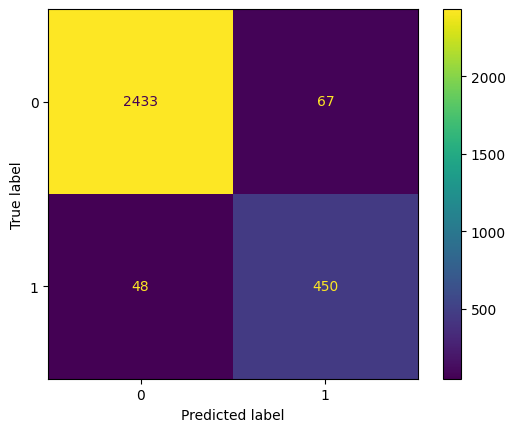

In [ ]:
# Ceamos una matrix de confusion
preds = rf2.best_estimator_.predict(x_test)
cm = confusion_matrix(y_test,preds,labels=rf2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf2.classes_)
disp.plot(values_format='')
plt.show()

El modelo predice más falsos positivos que falsos negativos, lo que significa que algunos empleados pueden ser identificados como en riesgo de renunciar o ser despedidos, cuando en realidad no es así. Pero este sigue siendo un modelo fuerte. Explorando las divisiones del arbol

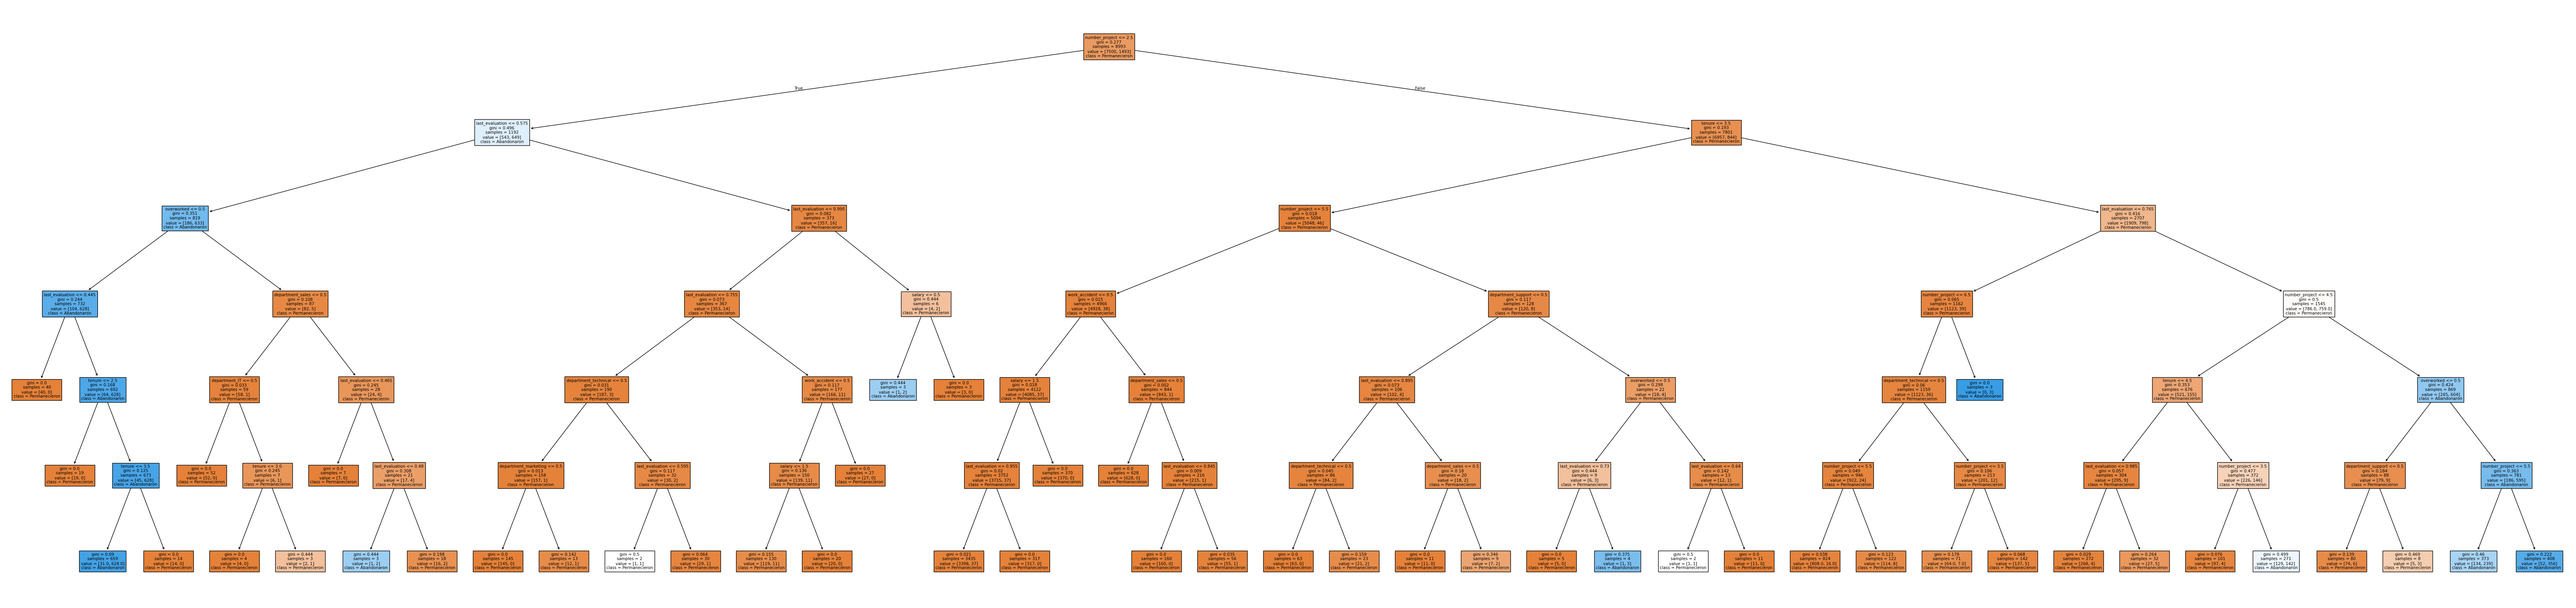

In [ ]:
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_,max_depth=6,feature_names=x.columns,
          class_names={0:'Permanecieron',1:'Abandonaron'},filled=True)
plt.show()

### Caracteristicas importantes de decision tree

In [ ]:
#tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=X.columns)
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_,
                                 columns=['gini_importance'],
                                 index=x.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

gini_importance
last_evaluation              0.343958
number_project               0.343385
tenure                       0.215681
overworked                   0.093498
department_support           0.001142
salary                       0.000910
department_sales             0.000607
department_technical         0.000418
work_accident                0.000183
department_IT                0.000139
department_marketing         0.000078

Visualizamos los datos con un grafico de barras

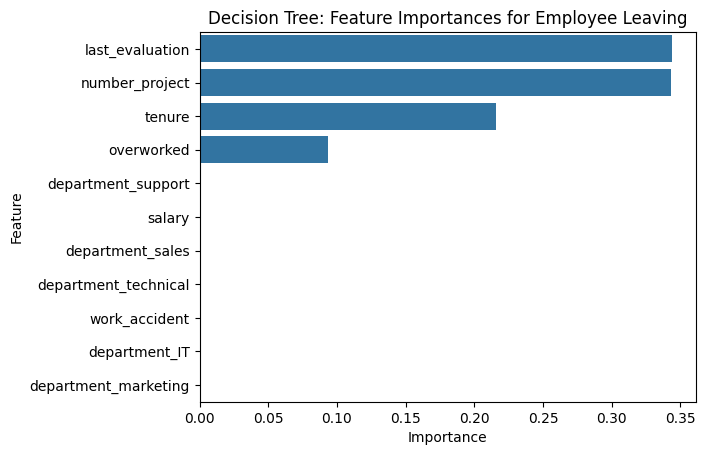

In [ ]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

## Caracteristicas importantes de Random forest


Ahora vamos a hacer la gráfica de las caracteristicas importantes en en el modelo de random forest

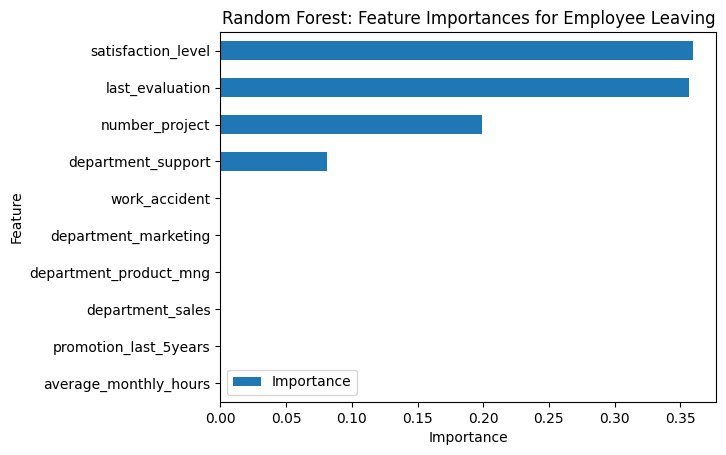

In [ ]:
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

La gráfica anterior muestra que en este modelo de bosque aleatorio, last_evaluation, number_project, tenure y overworked tienen la mayor importancia, en ese orden. Estas variables son las más útiles para predecir la variable de resultado, left, y son las mismas que las utilizadas por el modelo de árbol de decisión.

# **Reultados y evaluación**

Resumen de los resultados del modelo
**Regresión Logística**

- El modelo de regresión logística obtuvo una precisión del 80%, una sensibilidad (recall) del 83%, una puntuación F1 del 80% (todos promedios ponderados) y una precisión del 83% en el conjunto de prueba.

**Aprendizaje automático basado en árboles**

- Después de realizar ingeniería de características, el modelo de árbol de decisión obtuvo un AUC del 93.8%, una precisión del 87.0%, una sensibilidad (recall) del 90.4%, una puntuación F1 del 88.7% y una precisión del 96.2% en el conjunto de prueba. El bosque aleatorio superó modestamente al modelo de árbol de decisión.

## **Conclusión, recomendaciones, próximos pasos**
Los modelos y la importancia de las características extraídas de ellos confirman que los empleados de la empresa están sobrecargados.

Para retener a los empleados, se podrían presentar las siguientes recomendaciones a los interesados:

Limitar el número de proyectos en los que los empleados pueden trabajar. Considerar ascender a los empleados que llevan al menos cuatro años en la empresa, o investigar más a fondo por qué los empleados con cuatro años de antigüedad están tan insatisfechos. Recompensar a los empleados por trabajar horas extras, o no exigirles que lo hagan. Si los empleados no están familiarizados con las políticas de pago de horas extras de la empresa, informarles al respecto. Si las expectativas sobre la carga de trabajo y el tiempo libre no son explícitas, dejarlas claras. Realizar discusiones a nivel de toda la empresa y dentro de los equipos para comprender y abordar la cultura de trabajo de la empresa, tanto en general como en contextos específicos. Las altas puntuaciones de evaluación no deben reservarse para los empleados que trabajan más de 200 horas al mes. Considerar una escala proporcional para recompensar a los empleados que contribuyen más o se esfuerzan más.

## **Próximos pasos**

Puede que todavía esté justificado preocuparse por la fuga de datos. Podría ser prudente considerar cómo cambian las predicciones cuando se elimina last_evaluation de los datos. Es posible que las evaluaciones no se realicen con mucha frecuencia, en cuyo caso sería útil poder predecir la retención de empleados sin esta característica. También es posible que la puntuación de evaluación determine si un empleado se va o se queda, en cuyo caso podría ser útil cambiar de enfoque e intentar predecir la puntuación de rendimiento. Lo mismo podría decirse del nivel de satisfacción.

Para otro proyecto, se podría intentar construir un modelo K-means con estos datos y analizar los clústeres. Esto podría arrojar información valiosa.

